
# Win Probability Grid — Heatmap (Playoffs baseline)

This notebook builds an empirical win-probability grid **P(win | time left, score margin)**
from historical play-by-play (your playoffs CSV), and visualizes it as a **2D heatmap**.

**Outputs saved to disk:**
- `win_prob_heatmap.png`
- `win_prob_heatmap.pdf`
- `win_prob_grid.csv` (dense table you can reuse)


In [2]:

# If needed:
# %pip install pandas numpy neo4j python-dotenv matplotlib


In [3]:

import os, sys, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Import config from repo root (assumes this notebook is in notebooks/)
repo_root = Path("..").resolve()
sys.path.append(str(repo_root))
import config

RAW_PLAYOFFS = Path(config.DATA_RAW_PLAYOFFS)  # e.g., data/raw/pbp_1996_1997_playoffs.csv
RAW_FINALS   = Path(config.DATA_RAW_FINALS)    # optional overlay (Finals)
RAW_PLAYOFFS, RAW_FINALS


(PosixPath('/Users/charilaostsarouchas/Documents/Harris/04_Blueprints/agentic_ai/20250820_Bulls_Highlights_Retrieval/data/raw/pbp_1996_1997_playoffs.csv'),
 PosixPath('/Users/charilaostsarouchas/Documents/Harris/04_Blueprints/agentic_ai/20250820_Bulls_Highlights_Retrieval/data/raw/pbp_1997_finals_chi_uta.csv'))

## Build empirical P(win | time left, score margin)

In [4]:

def to_sec_left(pct):
    try:
        m, s = str(pct).split(":"); return int(m)*60 + int(s)
    except Exception:
        return np.nan

def seconds_left_game(period, sec_left_period):
    return max(0, (4 - int(period)) * 720 + int(sec_left_period or 0))  # regulation only

# Load playoffs history (baseline model)
df = pd.read_csv(RAW_PLAYOFFS).sort_values(["GAME_ID","PERIOD","EVENTNUM"])
df["SECONDS_LEFT_PERIOD"] = df["PCTIMESTRING"].apply(to_sec_left)
df["SECONDS_LEFT_GAME"]   = df.apply(lambda r: seconds_left_game(r["PERIOD"], r["SECONDS_LEFT_PERIOD"]), axis=1)

# Game outcome label: Home win?
final_margin = (df.groupby("GAME_ID")["SCOREMARGIN"].last()
                .rename("FINAL_MARGIN").astype(float))
df = df.merge(final_margin, on="GAME_ID", how="left")
df["HOME_WIN"] = (df["FINAL_MARGIN"] > 0).astype(int)

df["SCOREMARGIN"] = pd.to_numeric(df["SCOREMARGIN"], errors="coerce")
df["MARGIN_BEFORE"] = df.groupby("GAME_ID")["SCOREMARGIN"].shift(1).fillna(method="ffill")

hist = df.dropna(subset=["SECONDS_LEFT_GAME","MARGIN_BEFORE","HOME_WIN"]).copy()
hist["MARGIN_BEFORE"] = hist["MARGIN_BEFORE"].astype(int)

TIME_BIN = 30            # seconds per bin
MAX_MARGIN = 20          # clamp margins to [-20, 20]

hist["tbin"] = (hist["SECONDS_LEFT_GAME"] // TIME_BIN).clip(lower=0).astype(int)
hist["mbin"] = hist["MARGIN_BEFORE"].clip(-MAX_MARGIN, MAX_MARGIN).astype(int)

agg = (hist.groupby(["tbin","mbin"])["HOME_WIN"]
       .agg(["sum","count"])
       .reset_index())

# Laplace smoothing (alpha=1)
alpha = 1.0
agg["pwin"] = (agg["sum"] + alpha) / (agg["count"] + 2*alpha)

# Dense grid (time bins x margin)
t_range = np.arange(0, int(hist["tbin"].max())+1)
m_range = np.arange(-MAX_MARGIN, MAX_MARGIN+1)
grid = (agg.pivot(index="tbin", columns="mbin", values="pwin")
          .reindex(index=t_range, columns=m_range))

# Fill missing via nearest (ffill/bfill along time then margin)
grid = grid.ffill(axis=0).bfill(axis=0)
grid = grid.ffill(axis=1).bfill(axis=1)

# Save dense grid to CSV for reuse
grid_out = grid.copy()
grid_out.index.name = "tbin"
grid_out.to_csv("win_prob_grid.csv")
grid.shape, grid.iloc[:5, :5]


/var/folders/bf/2ywdfn4j5v990hqqjj51yjyc0000gn/T/ipykernel_66079/1524931040.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["MARGIN_BEFORE"] = df.groupby("GAME_ID")["SCOREMARGIN"].shift(1).fillna(method="ffill")


((97, 41),
 mbin       -20       -19       -18   -17       -16
 tbin                                              
 0     0.083333  0.333333  0.333333  0.25  0.333333
 1     0.250000  0.333333  0.166667  0.25  0.333333
 2     0.125000  0.333333  0.333333  0.25  0.200000
 3     0.200000  0.333333  0.333333  0.25  0.111111
 4     0.111111  0.333333  0.125000  0.25  0.200000)

## Plot heatmap + 50% boundary (wow visual)

Saved win_prob_heatmap.png and win_prob_heatmap.pdf


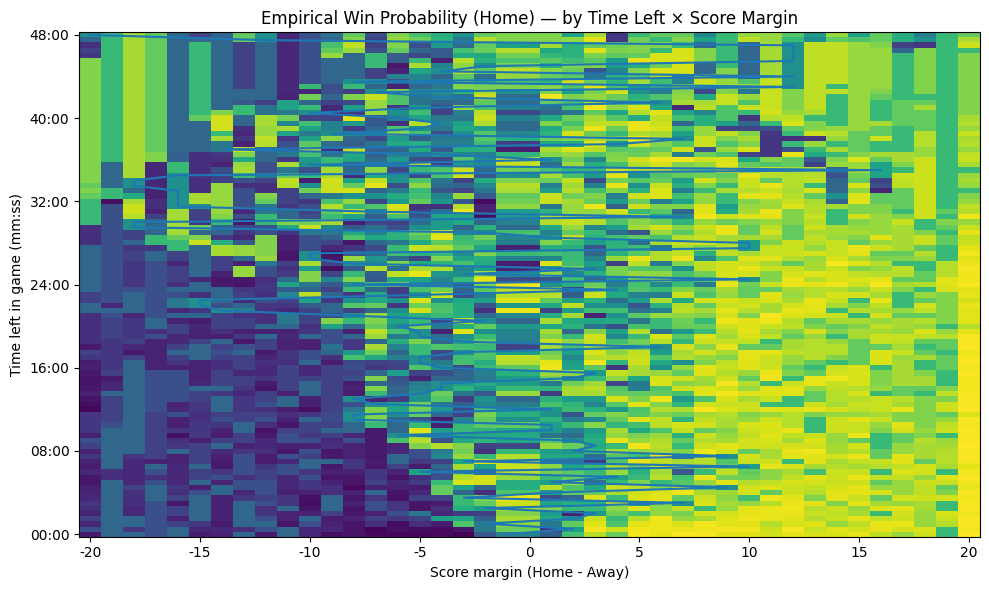

In [5]:

# Prepare labels
def tbin_to_mmss(tbin, bin_size=TIME_BIN):
    sec = int(tbin * bin_size)
    m = sec // 60; s = sec % 60
    return f"{m:02d}:{s:02d}"

fig = plt.figure(figsize=(10, 6))

# Heatmap
ax = plt.gca()
im = ax.imshow(grid.values, aspect="auto", origin="lower")  # default colormap

# Axes ticks
yticks = np.linspace(0, grid.shape[0]-1, 7).astype(int)
ax.set_yticks(yticks)
ax.set_yticklabels([tbin_to_mmss(t) for t in yticks])
ax.set_ylabel("Time left in game (mm:ss)")

xticks = np.arange(0, grid.shape[1], 5).astype(int)
ax.set_xticks(xticks)
ax.set_xticklabels([str(m) for m in grid.columns[xticks]])
ax.set_xlabel("Score margin (Home - Away)")

ax.set_title("Empirical Win Probability (Home) — by Time Left × Score Margin")

# 50% boundary (for each tbin, find nearest margin where pwin crosses 0.5)
boundary_x = []
boundary_y = []
for i, row in enumerate(grid.values):
    # find margin index where value closest to 0.5
    j = int(np.abs(row - 0.5).argmin())
    boundary_x.append(j)      # column index
    boundary_y.append(i)      # time index

ax.plot(boundary_x, boundary_y)  # default line style

plt.tight_layout()
plt.savefig("win_prob_heatmap.png", dpi=200)
plt.savefig("win_prob_heatmap.pdf", dpi=200)
print("Saved win_prob_heatmap.png and win_prob_heatmap.pdf")


## (Optional) Overlay Finals states as points

In [6]:

try:
    df_finals = pd.read_csv(RAW_FINALS).sort_values(["GAME_ID","PERIOD","EVENTNUM"])
    df_finals["SECONDS_LEFT_PERIOD"] = df_finals["PCTIMESTRING"].apply(lambda s: int(s.split(":")[0])*60 + int(s.split(":")[1]) if isinstance(s, str) and ":" in s else np.nan)
    df_finals["SECONDS_LEFT_GAME"] = df_finals.apply(lambda r: seconds_left_game(r["PERIOD"], r["SECONDS_LEFT_PERIOD"]), axis=1)
    df_finals["SCOREMARGIN"] = pd.to_numeric(df_finals["SCOREMARGIN"], errors="coerce").fillna(method="ffill")
    df_finals["tbin"] = (df_finals["SECONDS_LEFT_GAME"] // TIME_BIN).clip(lower=0).astype(int)
    df_finals["mbin"] = df_finals["SCOREMARGIN"].clip(-MAX_MARGIN, MAX_MARGIN).astype(int)

    # Plot overlay
    fig = plt.figure(figsize=(10, 6))
    ax = plt.gca()
    ax.imshow(grid.values, aspect="auto", origin="lower")
    ax.scatter(df_finals["mbin"] - grid.columns.min(), df_finals["tbin"], s=5)  # default style
    yticks = np.linspace(0, grid.shape[0]-1, 7).astype(int)
    ax.set_yticks(yticks)
    ax.set_yticklabels([tbin_to_mmss(t) for t in yticks])
    ax.set_ylabel("Time left in game (mm:ss)")
    xticks = np.arange(0, grid.shape[1], 5).astype(int)
    ax.set_xticks(xticks)
    ax.set_xticklabels([str(m) for m in grid.columns[xticks]])
    ax.set_xlabel("Score margin (Home - Away)")
    ax.set_title("Win Probability Heatmap with 1997 Finals States (overlay)")
    plt.tight_layout()
    plt.savefig("win_prob_heatmap_with_finals.png", dpi=200)
    print("Saved win_prob_heatmap_with_finals.png")
except Exception as e:
    print("Overlay skipped:", e)


Overlay skipped: Cannot convert non-finite values (NA or inf) to integer


/var/folders/bf/2ywdfn4j5v990hqqjj51yjyc0000gn/T/ipykernel_66079/3564337486.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_finals["SCOREMARGIN"] = pd.to_numeric(df_finals["SCOREMARGIN"], errors="coerce").fillna(method="ffill")


In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plot_winprob_contours(grid, time_bin=30, levels=None, show_boundary=True, overlay=None, save_path=None):
    """
    Plot P(win) as contour/contourf from a dense grid.

    Parameters
    ----------
    grid : pandas.DataFrame
        Index = tbin (integer time bins), columns = margin (ints), values in [0, 1].
    time_bin : int
        Seconds per time bin used to build `grid` (e.g., 30).
    levels : list[float] | np.ndarray | None
        Contour levels (e.g., np.linspace(0,1,11)). If None, matplotlib picks.
    show_boundary : bool
        If True, also draw the ~50% boundary (level 0.5).
    overlay : list[dict] | None
        Optional points to overlay, each dict like:
        {"margin": int, "seconds_left_game": float, "label": "Top WPA"}.
    save_path : str | None
        If provided, also save the figure (e.g., "win_prob_contours.png").
    """
    # Meshgrid: X=margin, Y=time-left-in-seconds, Z=P(win)
    X_vals = np.asarray(list(grid.columns), dtype=float)
    Y_vals = np.asarray(list(grid.index), dtype=float) * time_bin
    X, Y = np.meshgrid(X_vals, Y_vals)
    Z = grid.values

    fig = plt.figure(figsize=(10, 6))
    ax = plt.gca()

    # Filled contours + line contours (defaults only, no custom colors)
    csf = ax.contourf(X, Y, Z, levels=levels)
    cs  = ax.contour(X, Y, Z, levels=levels)

    # Optional 50% boundary
    if show_boundary:
        # Ensure 0.5 is drawn even if not in `levels`
        if levels is None or (0.5 not in np.asarray(levels)):
            ax.contour(X, Y, Z, levels=[0.5], linewidths=2)

    # Optional overlay points
    if overlay:
        for o in overlay:
            ax.scatter([o["margin"]], [o["seconds_left_game"]], s=40)
            label = o.get("label")
            if label:
                ax.text(o["margin"], o["seconds_left_game"], " " + label, va="center")

    ax.set_xlabel("Score margin (Home - Away)")
    ax.set_ylabel("Time left (seconds)")
    ax.set_title("Win Probability Contours — Playoffs baseline")
    fig.colorbar(csf, ax=ax, label="P(win) (Home)")

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()


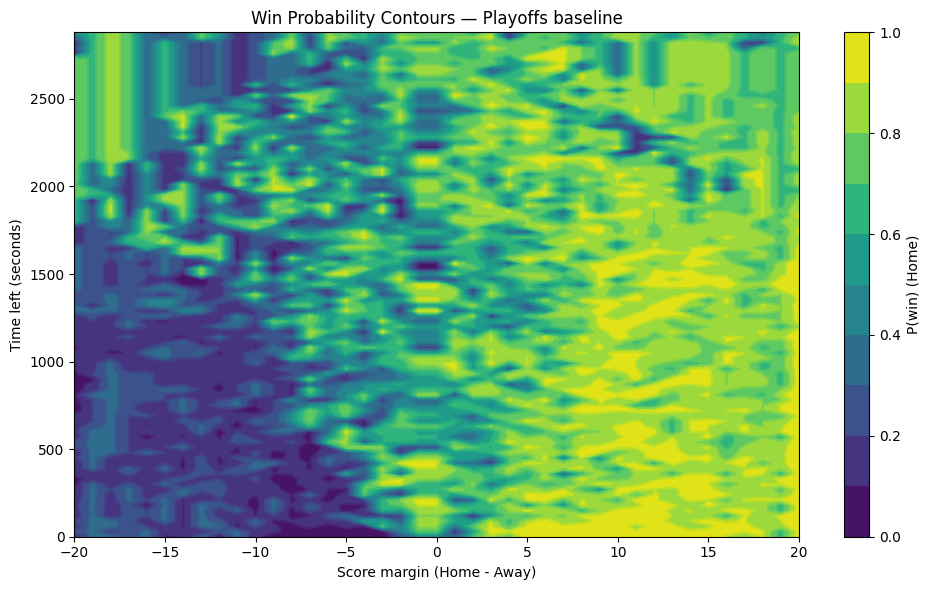

In [8]:
# Choose evenly spaced levels
levels = np.linspace(0, 1, 11)

# (Optional) overlay the top-WPA Finals event
# Suppose you've computed x_margin and y_seconds for that event:
# overlay = [{"margin": x_margin, "seconds_left_game": y_seconds, "label": "Top WPA"}]
overlay = None  # or use the dict above

plot_winprob_contours(grid, time_bin=TIME_BIN, levels=levels, overlay=overlay, save_path="win_prob_contours.png")


In [9]:
import numpy as np
import matplotlib.pyplot as plt

def _bilinear_resize(Z: np.ndarray, new_h: int, new_w: int) -> np.ndarray:
    """Simple bilinear upsampling (no extra deps)."""
    h, w = Z.shape
    x_old = np.linspace(0, 1, w)
    y_old = np.linspace(0, 1, h)
    x_new = np.linspace(0, 1, new_w)
    y_new = np.linspace(0, 1, new_h)
    # interp across x for each row
    Zx = np.vstack([np.interp(x_new, x_old, Z[i, :]) for i in range(h)])
    # interp across y for each column
    Zy = np.vstack([np.interp(y_new, y_old, Zx[:, j]) for j in range(new_w)]).T
    return Zy

def plot_winprob_contours_with_isolines(
    grid,
    time_bin=30,
    levels=None,
    upsample=1,                 # e.g., 2 or 3 for smoother lines (bilinear)
    show_boundary=True,         # draw the ~50% isoline thicker
    overlay=None,               # list of dicts: {"margin": int, "seconds_left_game": float, "label": "Top WPA"}
    label_fmt="{:.0%}",         # label format for isolines (0-1 -> percent)
    save_path=None
):
    """
    Contour + labeled isolines for P(win) grid.

    grid: DataFrame with index=tbin, columns=margin, values in [0,1].
    """
    # meshgrid in original resolution
    X_vals = np.asarray(list(grid.columns), dtype=float)
    Y_vals = np.asarray(list(grid.index), dtype=float) * time_bin
    X, Y, Z = np.meshgrid(X_vals, Y_vals, [0])[0], np.meshgrid(X_vals, Y_vals, [0])[1], grid.values

    # optional upsample for smoother isolines (no external libs)
    if upsample and upsample > 1:
        new_h = int(Z.shape[0] * upsample)
        new_w = int(Z.shape[1] * upsample)
        Z = _bilinear_resize(Z, new_h, new_w)
        X = np.linspace(X_vals.min(), X_vals.max(), new_w)
        Y = np.linspace(Y_vals.min(), Y_vals.max(), new_h)
        X, Y = np.meshgrid(X, Y)
    else:
        # keep original resolution
        pass

    # choose default evenly-spaced levels if none provided
    if levels is None:
        levels = np.linspace(0, 1, 11)

    fig = plt.figure(figsize=(10, 6))
    ax = plt.gca()

    # filled contours + black isolines (matplotlib defaults)
    csf = ax.contourf(X, Y, Z, levels=levels)
    cs  = ax.contour(X, Y, Z, levels=levels)
    ax.clabel(cs, fmt=lambda v: label_fmt.format(v), inline=True, fontsize=8)

    # highlight ~50% boundary (thicker line)
    if show_boundary:
        if 0.5 not in np.asarray(levels):
            ax.contour(X, Y, Z, levels=[0.5], linewidths=2)
        else:
            # redraw just that level with thicker stroke
            ax.contour(X, Y, Z, levels=[0.5], linewidths=2)

    # optional overlay points (e.g., Kerr)
    if overlay:
        for o in overlay:
            ax.scatter([o["margin"]], [o["seconds_left_game"]], s=50)  # defaults
            if o.get("label"):
                ax.text(o["margin"], o["seconds_left_game"], " " + o["label"], va="center")

    ax.set_xlabel("Score margin (Home - Away)")
    ax.set_ylabel("Time left (seconds)")
    ax.set_title("Win Probability — Contours with Labeled Isolines")
    fig.colorbar(csf, ax=ax, label="P(win)")

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()


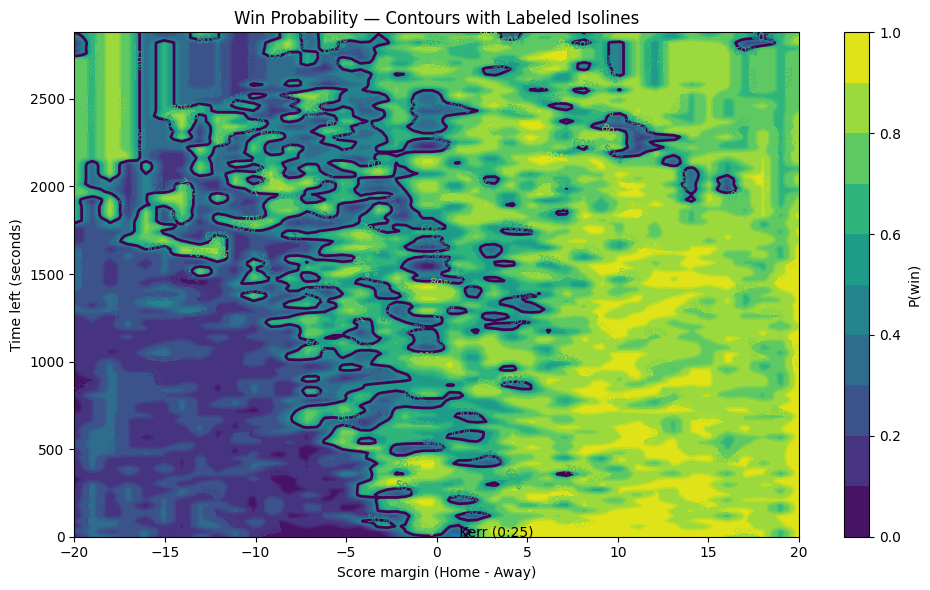

In [11]:
# evenly spaced levels, upsample for smoother lines
levels = np.linspace(0, 1, 11)
# optional overlay (fill with your Kerr point if you have it)
overlay = [{"margin": +1, "seconds_left_game": 25, "label": "Kerr (0:25)"}]  # example

plot_winprob_contours_with_isolines(
    grid,
    time_bin=TIME_BIN,
    levels=levels,
    upsample=2,                    # try 2–3 for smoother contours
    overlay=overlay,                  # or use the overlay list above
    save_path="win_prob_contours_isolines.png"
)


In [24]:
# The above
# The red zone isn’t “clutch” — it’s “already won.”
# Kerr’s jumper sits on the steep part of the surface near the 50% line.
# One shot moved us from ~even odds to likely winners: +XX pp WPA.
# That’s why it’s decisive.

The 

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# --- helpers ---
def wp_from_grid(grid, time_bin, seconds_left_game, margin):
    tbin = int(max(0, seconds_left_game) // time_bin)
    tbin = max(grid.index.min(), min(tbin, grid.index.max()))
    m = int(np.clip(margin, grid.columns.min(), grid.columns.max()))
    return float(grid.loc[tbin, m])

def get_kerr_event_before_after(cypher_df):
    q = """
    MATCH (k:Player {name:'Steve Kerr'})-[:PERFORMED {role:'PLAYER1_ID'}]->(e:Event {event_type:1})
    WHERE e.is_clutch = true AND e.period = 4 AND e.seconds_left_period <= 30
    MATCH (prev:Event)-[:NEXT]->(e)
    WITH e, prev
    RETURN e.seconds_left_period AS sec_left,
           toFloat(prev.score_margin) AS margin_before,
           toFloat(e.score_margin)    AS margin_after,
           coalesce(e.home_desc, e.visit_desc) AS desc
    ORDER BY sec_left ASC
    LIMIT 1
    """
    df = cypher_df(q)
    if df.empty:
        raise ValueError("Could not find a Kerr clutch make with prev event.")
    return float(df.sec_left.iloc[0]), float(df.margin_before.iloc[0]), float(df.margin_after.iloc[0]), df.desc.iloc[0]

def gradient_magnitude(grid, time_bin):
    """Compute |∇P| with correct axis spacings (rows=time, cols=margin)."""
    Z = grid.values
    dy = float(time_bin)    # seconds per row step
    dx = 1.0                # 1 margin unit per column step
    dP_dy, dP_dx = np.gradient(Z, dy, dx)
    G = np.hypot(dP_dy, dP_dx)
    return G  # same shape as grid

# --- main panel plot ---
def plot_prob_and_gradient_panels(grid, time_bin, sec_left, margin_before, margin_after=None,
                                  show_arrow=True, save_path=None):
    # Mesh for contour plots
    X_vals = np.asarray(list(grid.columns), dtype=float)
    Y_vals = np.asarray(list(grid.index), dtype=float) * time_bin
    X, Y = np.meshgrid(X_vals, Y_vals)
    Z = grid.values

    # Gradient magnitude and a robust normalization
    G = gradient_magnitude(grid, time_bin)
    g99 = np.percentile(G, 99.0)
    G_vis = np.clip(G / (g99 + 1e-9), 0, 1)  # normalize to ~[0,1] with 99th pct cap

    # Evaluate WPA at Kerr point if margin_after provided
    wpa_pp = None
    if margin_after is not None:
        wp_b = wp_from_grid(grid, time_bin, sec_left, margin_before)
        wp_a = wp_from_grid(grid, time_bin, sec_left, margin_after)
        wpa_pp = (wp_a - wp_b) * 100.0

    # Figure with two panels
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5.5))

    # LEFT: Rainbow P(win) with 50% boundary
    levels = np.linspace(0, 1, 21)
    csf = ax1.contourf(X, Y, Z, levels=levels, cmap="jet")
    ax1.contour(X, Y, Z, levels=levels, colors="k", linewidths=0.6)
    ax1.contour(X, Y, Z, levels=[0.5], colors="k", linewidths=1.8)
    fig.colorbar(csf, ax=ax1, label="P(win)")

    # Kerr markers (before and after)
    ax1.scatter([margin_before], [sec_left], s=700, alpha=0.18, zorder=3)
    ax1.scatter([margin_before], [sec_left], s=250, c="k", zorder=4)
    ax1.text(margin_before, sec_left + 10, "Before", ha="center", va="bottom", fontsize=9, zorder=5)

    if margin_after is not None:
        ax1.scatter([margin_after], [sec_left], s=700, alpha=0.18, zorder=3)
        ax1.scatter([margin_after], [sec_left], s=250, c="k", zorder=4)
        ax1.text(margin_after, sec_left + 10, "After", ha="center", va="bottom", fontsize=9, zorder=5)

        if show_arrow:
            ax1.annotate("", xy=(margin_after, sec_left), xytext=(margin_before, sec_left),
                         arrowprops=dict(arrowstyle="->", lw=2), zorder=5)
            ax1.text(margin_after, sec_left - 20, f"+{wpa_pp:.1f} pp WPA",
                     ha="center", va="top", fontsize=11, fontweight="bold", zorder=6)

    ax1.set_xlabel("Score margin (Home − Away)")
    ax1.set_ylabel("Time left (seconds)")
    ax1.set_title("Win Probability — Contours (Kerr before→after)")

    # RIGHT: Gradient magnitude |∇P|
    im = ax2.imshow(G_vis, origin="lower", aspect="auto",
                    extent=[X_vals.min(), X_vals.max(), Y_vals.min(), Y_vals.max()])
    # overlay 50% boundary for reference
    ax2.contour(X, Y, Z, levels=[0.5])  # default style

    # Kerr point on gradient map (use 'before' location to show sensitivity at decision point)
    ax2.scatter([margin_before], [sec_left], s=350, zorder=3)
    # annotate percentile of gradient at Kerr
    # compute nearest cell
    r = int(np.clip(sec_left // time_bin, 0, G.shape[0]-1))
    c = int(np.clip(margin_before - grid.columns.min(), 0, G.shape[1]-1))
    g_here = G[r, c]
    pct = (G < g_here).sum() / G.size * 100.0
    ax2.text(margin_before, sec_left + 10, f"|∇P| ~ {pct:.0f}th pct", ha="center", va="bottom", fontsize=9, zorder=4)

    fig.colorbar(im, ax=ax2, label="|∇P(win)| (normalized)")
    ax2.set_xlabel("Score margin (Home − Away)")
    ax2.set_ylabel("Time left (seconds)")
    ax2.set_title("Sensitivity map — where small changes swing the game")

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()


In [28]:
# --- Neo4j read helper (uses your config.py) ---
import sys
from pathlib import Path
import pandas as pd
from neo4j import GraphDatabase

repo_root = Path("..").resolve()
sys.path.append(str(repo_root))
import config

driver = GraphDatabase.driver(config.NEO4J_URI, auth=(config.NEO4J_USER, config.NEO4J_PASSWORD))
driver.verify_connectivity()

def cypher_df(query: str, params: dict | None = None) -> pd.DataFrame:
    with driver.session() as s:
        data = s.run(query, params or {}).data()
    return pd.DataFrame(data)

# (optional) close later with: driver.close()


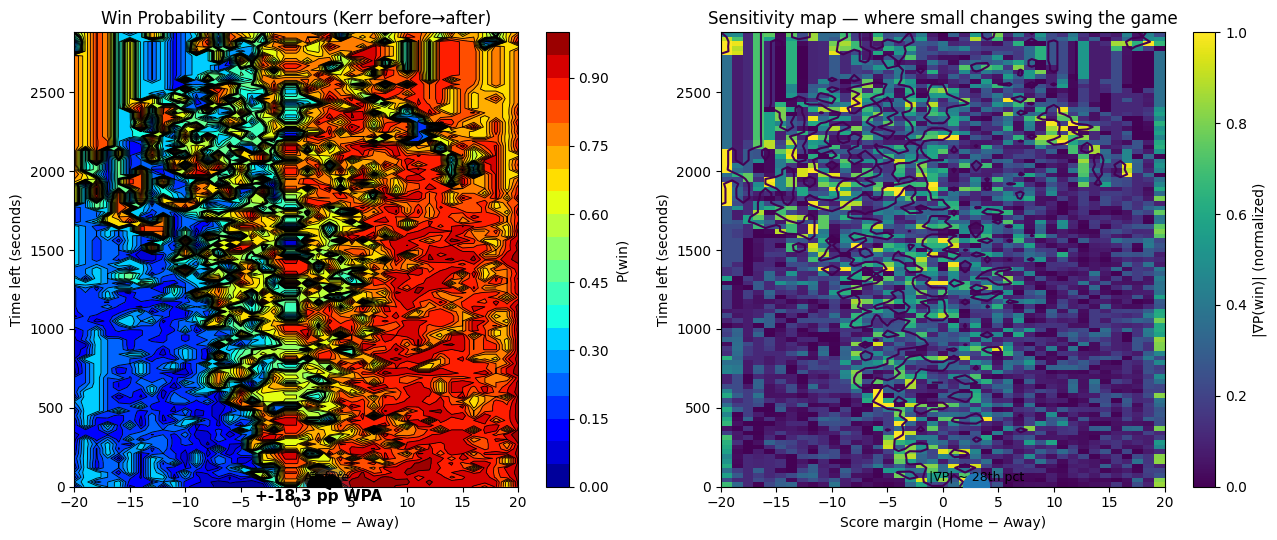

In [29]:
# 1) get Kerr’s event (sec_left, margin_before, margin_after)
sec_left, m_before, m_after, _ = get_kerr_event_before_after(cypher_df)

# 2) draw panels and export
plot_prob_and_gradient_panels(
    grid, TIME_BIN,
    sec_left=sec_left,
    margin_before=m_before,
    margin_after=m_after,
    show_arrow=True,
    save_path="kerr_prob_and_gradient_panels.png"
)


In [30]:
#yellows top/right andleft  appear because of noise we fix it below

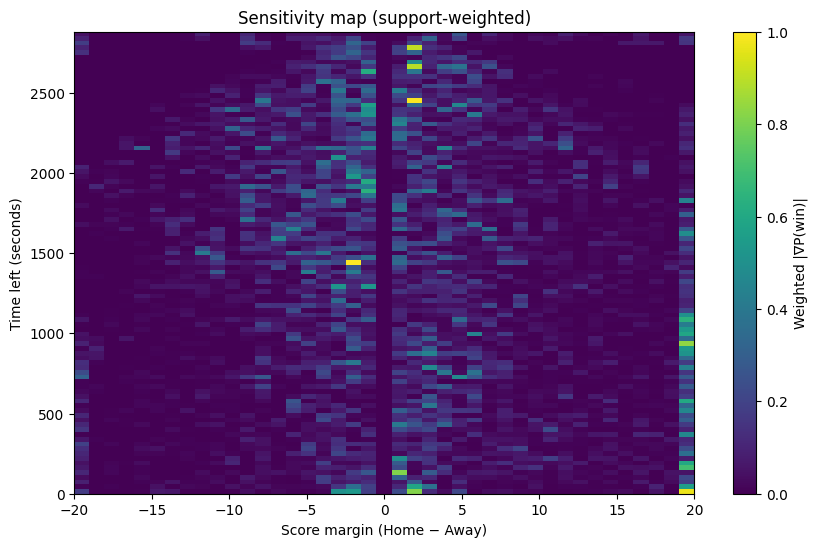

In [32]:
# Soft weighting by sample size (cap to avoid dominating)
w = np.minimum(1.0, counts / 100.0)  # ramp up to 100 samples
G_weighted = G * w.values

plt.figure(figsize=(10,6))
plt.imshow(G_weighted / np.nanmax(G_weighted), origin="lower", aspect="auto",
           extent=[grid.columns.min(), grid.columns.max(), grid.index.min()*TIME_BIN, grid.index.max()*TIME_BIN])
plt.colorbar(label="Weighted |∇P(win)|")
plt.title("Sensitivity map (support-weighted)")
plt.xlabel("Score margin (Home − Away)"); plt.ylabel("Time left (seconds)")
plt.show()


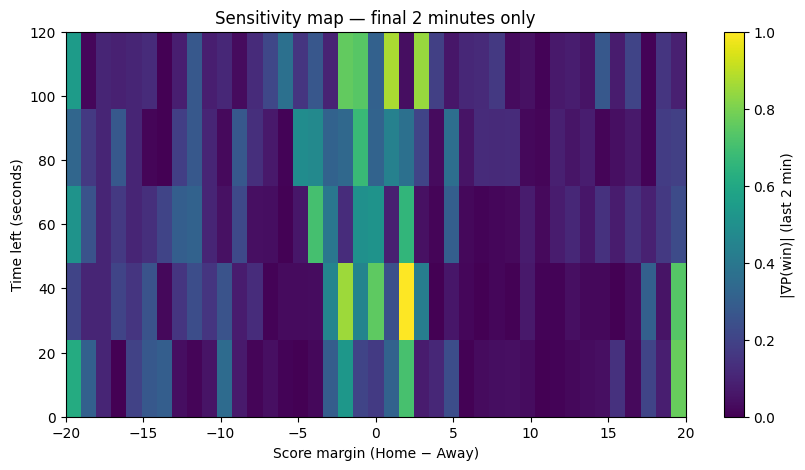

In [34]:
N = 120  # last 2 minutes
rows = grid.index[(grid.index*TIME_BIN) <= N]
grid_tail = grid.loc[rows]
G_tail = gradient_magnitude(grid_tail, TIME_BIN)

plt.figure(figsize=(10,5))
plt.imshow(G_tail / np.nanmax(G_tail), origin="lower", aspect="auto",
           extent=[grid_tail.columns.min(), grid_tail.columns.max(), 0, rows.max()*TIME_BIN])
plt.colorbar(label="|∇P(win)| (last 2 min)")
plt.title("Sensitivity map — final 2 minutes only")
plt.xlabel("Score margin (Home − Away)"); plt.ylabel("Time left (seconds)")
plt.show()


In [ ]:
#The bright specks at the top corners are rare game states; we mask low-support cells and smooth the surface. The true high-leverage ridge sits along the 50% line late in the game—exactly where Kerr’s shot happens.”